<a href="https://colab.research.google.com/github/bhatnira/Acetylcholinesterase-Inhibitor-Discovery/blob/main/classificationModelling_modredFeatures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modred Feature Based Classification Modelling

## Introduction
Modred descriptor calculator is flexible,open source user friendly, able to calculate 1800 2D and 3D descriptors, and twice as fast as compared to PaDEL descriptor calculator, and can calculate descriptors for larger molecules   (Moriwaki et al., 2018).

## Data loading and Preprocessing



In [ ]:
# For Reproducibility
import numpy as np
np.random.seed(42)


In [ ]:
# Mount Drive in Colab environment
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Data loading
Acquisition of the primary molecular dataset of the human acetylcholinesterase inhibitor was done from ChEMBL(ID:ChEMBL22). From 18,204 inhibitor entries, 4077 compounds with reported IC50 value and validated SMILE annotations were chosen, with redundant chemical structures resolved by randomly selecting one from the most frequently occurring activity label group. The resulting dataset comprises 2,330 instances labeled as positive and 1,747 instances labeled as negative. Molecules with an IC50 value less than 1uM were labeled as positives, and greater than 1 uM were labeled as negatives.  

Due to requirement of huge amount of time for descriptor generation, features were generated elesewhere and imported here. Again, two feature sets were created: one underwent LASSO treatment, which was employed in classical, ensemble, and deep learning models. The other set, devoid of LASSO treatment, was utilized in the AutoML method, as it incorporates its own feature processing and selection methodology within its pipeline.




In [ ]:
# Load dataset
import pandas as pd
df=pd.read_excel("/content/drive/MyDrive/Predictive-Generative-transfer learning/Previous Devs/Part_3_1_ModredFeatures/ModredFeatures_cleaned (2).xlsx")
df.head(5)

,Molecule ChEMBL ID,Smiles,IC50,classLabel,IsValidSMILES,Morgan_FP,Molecule,Fingerprint,PCA1,PCA2,...,1603,1604,1605,1606,1607,1608,1609,1610,1611,1612
0,CHEMBL94,CNC(=O)Oc1ccc2c(c1)[C@]1(C)CCN(C)[C@@H]1N2C,28.0,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e880b0>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-1.738898,-1.494784,...,10.241566,71.128822,275.163377,6.711302,760,36,112,139,7.590278,4.319444
1,CHEMBL207777,Cc1ccccc1NC(=O)Oc1ccc2c(c1)[C@]1(C)CO[C@@H](C1)O2,97.0,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e88190>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-1.014164,-1.325272,...,10.285513,73.449036,325.131408,7.561196,1406,39,134,160,7.090278,5.055556
2,CHEMBL205967,CCNC(=O)Oc1ccc2c(c1)[C@]1(C)CO[C@@H](C1)O2,2420.0,0,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e88270>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-1.235565,-1.559108,...,10.058909,67.227266,263.115758,7.308771,700,30,104,124,6.118056,4.111111
3,CHEMBL60119,Cc1ccc2c(N)c3c(nc2c1)CCCC3,100.0,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e88430>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,2.705664,0.148113,...,9.904837,49.157421,212.131349,6.629105,395,27,88,106,4.666667,3.444444
4,CHEMBL294525,CCCCCCCNc1c2c(nc3cc([N+](=O)[O-])ccc13)CCCC2,290.0,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e884a0>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,3.600017,-0.978574,...,10.109078,59.624354,341.210327,6.561737,1596,39,126,147,7.527778,5.722222


In [ ]:
# Installing RDKit from PyPI
!pip install rdkit-pypi

In [ ]:
# Drop any feature containing null values
df.dropna(axis=1)

,Molecule ChEMBL ID,Smiles,IC50,classLabel,IsValidSMILES,Morgan_FP,Molecule,Fingerprint,PCA1,PCA2,...,1603,1604,1605,1606,1607,1608,1609,1610,1611,1612
0,CHEMBL94,CNC(=O)Oc1ccc2c(c1)[C@]1(C)CCN(C)[C@@H]1N2C,28.00,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e880b0>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-1.738898,-1.494784,...,10.241566,71.128822,275.163377,6.711302,760,36,112,139,7.590278,4.319444
1,CHEMBL207777,Cc1ccccc1NC(=O)Oc1ccc2c(c1)[C@]1(C)CO[C@@H](C1)O2,97.00,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e88190>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-1.014164,-1.325272,...,10.285513,73.449036,325.131408,7.561196,1406,39,134,160,7.090278,5.055556
2,CHEMBL205967,CCNC(=O)Oc1ccc2c(c1)[C@]1(C)CO[C@@H](C1)O2,2420.00,0,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e88270>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-1.235565,-1.559108,...,10.058909,67.227266,263.115758,7.308771,700,30,104,124,6.118056,4.111111
3,CHEMBL60119,Cc1ccc2c(N)c3c(nc2c1)CCCC3,100.00,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e88430>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,2.705664,0.148113,...,9.904837,49.157421,212.131349,6.629105,395,27,88,106,4.666667,3.444444
4,CHEMBL294525,CCCCCCCNc1c2c(nc3cc([N+](=O)[O-])ccc13)CCCC2,290.00,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e884a0>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,3.600017,-0.978574,...,10.109078,59.624354,341.210327,6.561737,1596,39,126,147,7.527778,5.722222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4072,CHEMBL4077157,O=C(Nc1ccc(CN2CCOCC2)cc1C(=O)C(=O)N1C(=O)CCC1=...,229.08,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfdd327c30>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-0.478199,1.261641,...,10.351789,82.995012,449.158685,8.020691,3211,52,172,202,10.472222,7.277778
4073,CHEMBL3906317,COc1cccc2c1C=[N+](c1ccccc1C(F)(F)F)CC2.[Br-],10000.00,0,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfdd327ca0>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-0.671263,-0.016301,...,10.161573,56.557574,306.110025,8.273244,996,37,118,140,7.479167,4.777778
4074,CHEMBL4800328,COc1cccc2cc[n+](-c3ccc(C)cc3)cc12.[Br-],1080.00,0,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfdd327d10>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-0.586529,-0.433179,...,9.892578,52.541038,250.122641,7.146361,702,30,100,118,5.416667,4.250000
4075,CHEMBL4797670,COc1ccc(-[n+]2ccc3cccc(OC)c3c2)cc1.[Br-],140.00,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfdd327d80>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-0.677524,-0.748477,...,9.924515,53.723654,266.117555,7.392154,830,32,104,123,5.666667,4.583333


In [ ]:
# Feature Set for tpot modelling
feature1=df.loc[:, 0:]

In [ ]:
feature1

,0,1,2,3,4,5,6,7,8,9,...,1603,1604,1605,1606,1607,1608,1609,1610,1611,1612
0,15.758458,13.904596,0,1,25.430044,2.626653,4.995416,25.430044,1.271502,3.953065,...,10.241566,71.128822,275.163377,6.711302,760,36,112,139,7.590278,4.319444
1,19.327092,15.013529,0,0,31.410803,2.536198,4.987137,31.410803,1.308783,4.136535,...,10.285513,73.449036,325.131408,7.561196,1406,39,134,160,7.090278,5.055556
2,15.015501,12.459139,0,0,24.338848,2.535959,4.985897,24.338848,1.280992,3.896678,...,10.058909,67.227266,263.115758,7.308771,700,30,104,124,6.118056,4.111111
3,12.784941,10.238061,0,0,21.000595,2.470206,4.940412,21.000595,1.312537,3.734355,...,9.904837,49.157421,212.131349,6.629105,395,27,88,106,4.666667,3.444444
4,19.108462,14.477050,0,0,32.583468,2.490801,4.981601,32.583468,1.303339,4.136941,...,10.109078,59.624354,341.210327,6.561737,1596,39,126,147,7.527778,5.722222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4072,25.719712,20.598881,0,1,43.114540,2.446042,4.863504,43.114540,1.306501,4.422666,...,10.351789,82.995012,449.158685,8.020691,3211,52,172,202,10.472222,7.277778
4073,17.223949,14.052119,0,1,28.313363,2.459642,4.919285,28.313363,1.286971,4.029055,...,10.161573,56.557574,306.110025,8.273244,996,37,118,140,7.479167,4.777778
4074,14.837312,11.687088,0,1,25.279776,2.423061,4.846123,25.279776,1.330515,3.885636,...,9.892578,52.541038,250.122641,7.146361,702,30,100,118,5.416667,4.250000
4075,15.435029,12.076544,0,1,26.949317,2.424109,4.848218,26.949317,1.347466,3.931577,...,9.924515,53.723654,266.117555,7.392154,830,32,104,123,5.666667,4.583333


In [ ]:
# Get the list of columns containing NaN values
columns_with_nan = feature1.columns[feature1.isna().any()].tolist()
print(columns_with_nan)

[]


In [ ]:
import pandas as pd

def check_non_numeric(df):
    non_numeric_columns = []
    for column in df.columns:
        try:
            pd.to_numeric(df[column])
        except ValueError:
            non_numeric_columns.append(column)
    return non_numeric_columns

# Assuming your DataFrame is named 'df'
non_numeric_columns = check_non_numeric(feature1)
print("Columns with non-numeric values:", non_numeric_columns)


Columns with non-numeric values: [139, 140, 141, 142, 148, 149, 150, 151, 157, 158, 159, 160, 166, 167, 168, 169, 175, 176, 177, 178, 184, 185, 186, 187, 193, 194, 195, 196, 202, 203, 204, 205, 211, 212, 213, 214, 220, 221, 222, 223, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 341, 342, 343, 344, 345, 346, 347, 348, 349, 355, 356, 357, 358, 364, 365, 366, 367, 373, 374, 375, 376, 382, 383, 384, 385, 391, 392, 393, 394, 400, 401, 402, 403, 409, 410, 411, 412, 418, 419, 420, 421, 427, 428, 429, 430, 436, 437, 438, 439, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 461, 462, 463, 464, 469, 470, 471, 472, 477, 478, 479, 480, 485, 486, 487, 488, 493, 494, 495, 496, 501, 502, 503, 504, 509, 510, 511, 512, 517, 518, 519, 520, 525, 526, 527, 528, 533, 534, 535, 536, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 557, 558, 559, 560, 565, 566, 567, 568, 573, 574, 575, 576, 581, 582, 583, 584, 589, 590, 591, 592, 597, 598, 599, 600, 605, 606, 607, 6

In [ ]:
import pandas as pd

def drop_non_numeric(df):
    non_numeric_columns = df.select_dtypes(exclude=['number']).columns
    df = df.drop(columns=non_numeric_columns)
    return df

# Assuming your DataFrame is named 'feature1'
feature1 = drop_non_numeric(feature1)
print("DataFrame after dropping non-numeric columns:")
feature1


DataFrame after dropping non-numeric columns:


,0,1,2,3,4,5,6,7,8,9,...,1603,1604,1605,1606,1607,1608,1609,1610,1611,1612
0,15.758458,13.904596,0,1,25.430044,2.626653,4.995416,25.430044,1.271502,3.953065,...,10.241566,71.128822,275.163377,6.711302,760,36,112,139,7.590278,4.319444
1,19.327092,15.013529,0,0,31.410803,2.536198,4.987137,31.410803,1.308783,4.136535,...,10.285513,73.449036,325.131408,7.561196,1406,39,134,160,7.090278,5.055556
2,15.015501,12.459139,0,0,24.338848,2.535959,4.985897,24.338848,1.280992,3.896678,...,10.058909,67.227266,263.115758,7.308771,700,30,104,124,6.118056,4.111111
3,12.784941,10.238061,0,0,21.000595,2.470206,4.940412,21.000595,1.312537,3.734355,...,9.904837,49.157421,212.131349,6.629105,395,27,88,106,4.666667,3.444444
4,19.108462,14.477050,0,0,32.583468,2.490801,4.981601,32.583468,1.303339,4.136941,...,10.109078,59.624354,341.210327,6.561737,1596,39,126,147,7.527778,5.722222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4072,25.719712,20.598881,0,1,43.114540,2.446042,4.863504,43.114540,1.306501,4.422666,...,10.351789,82.995012,449.158685,8.020691,3211,52,172,202,10.472222,7.277778
4073,17.223949,14.052119,0,1,28.313363,2.459642,4.919285,28.313363,1.286971,4.029055,...,10.161573,56.557574,306.110025,8.273244,996,37,118,140,7.479167,4.777778
4074,14.837312,11.687088,0,1,25.279776,2.423061,4.846123,25.279776,1.330515,3.885636,...,9.892578,52.541038,250.122641,7.146361,702,30,100,118,5.416667,4.250000
4075,15.435029,12.076544,0,1,26.949317,2.424109,4.848218,26.949317,1.347466,3.931577,...,9.924515,53.723654,266.117555,7.392154,830,32,104,123,5.666667,4.583333


In [ ]:

# Calculate variance for each column in 'feature1'
variances = feature1.var()
# Threshold for low variability.
threshold = 0
# Identify columns with variability below the threshold.
low_variability_columns = variances[variances == threshold].index
# Drop columns with low variability from the DataFrame 'feature1'.
feature1.drop(columns=low_variability_columns, inplace=True)
feature1

,0,1,2,3,4,5,6,7,8,9,...,1603,1604,1605,1606,1607,1608,1609,1610,1611,1612
0,15.758458,13.904596,0,1,25.430044,2.626653,4.995416,25.430044,1.271502,3.953065,...,10.241566,71.128822,275.163377,6.711302,760,36,112,139,7.590278,4.319444
1,19.327092,15.013529,0,0,31.410803,2.536198,4.987137,31.410803,1.308783,4.136535,...,10.285513,73.449036,325.131408,7.561196,1406,39,134,160,7.090278,5.055556
2,15.015501,12.459139,0,0,24.338848,2.535959,4.985897,24.338848,1.280992,3.896678,...,10.058909,67.227266,263.115758,7.308771,700,30,104,124,6.118056,4.111111
3,12.784941,10.238061,0,0,21.000595,2.470206,4.940412,21.000595,1.312537,3.734355,...,9.904837,49.157421,212.131349,6.629105,395,27,88,106,4.666667,3.444444
4,19.108462,14.477050,0,0,32.583468,2.490801,4.981601,32.583468,1.303339,4.136941,...,10.109078,59.624354,341.210327,6.561737,1596,39,126,147,7.527778,5.722222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4072,25.719712,20.598881,0,1,43.114540,2.446042,4.863504,43.114540,1.306501,4.422666,...,10.351789,82.995012,449.158685,8.020691,3211,52,172,202,10.472222,7.277778
4073,17.223949,14.052119,0,1,28.313363,2.459642,4.919285,28.313363,1.286971,4.029055,...,10.161573,56.557574,306.110025,8.273244,996,37,118,140,7.479167,4.777778
4074,14.837312,11.687088,0,1,25.279776,2.423061,4.846123,25.279776,1.330515,3.885636,...,9.892578,52.541038,250.122641,7.146361,702,30,100,118,5.416667,4.250000
4075,15.435029,12.076544,0,1,26.949317,2.424109,4.848218,26.949317,1.347466,3.931577,...,9.924515,53.723654,266.117555,7.392154,830,32,104,123,5.666667,4.583333


In [ ]:
target=df['classLabel']
target.head()

0    1
1    1
2    0
3    1
4    1
Name: classLabel, dtype: int64

### Feature Selection

LASSO (least absolute shrinkage and selection operator) method operated within the framework of ridge regression and subset selection, LASSO efficiently chooses a single feature from highly correlated groups(Muthukrishnan & Rohini, 2016).Features selection  was done through Lasso regression with five fold cross validation alpha selection, and based upon non-zero coefficients.

In [ ]:
# Importing necessary libraries
import pandas as pd
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
# Feature scaling
scaler = StandardScaler()
X = scaler.fit_transform(feature1)
# Lasso model with cross-validated alpha selection
lasso_model = LassoCV(cv=5)
# Fit the Lasso model to the standardized feature matrix (X) and the target variable ('classLabel')
lasso_model.fit(X, df['classLabel'])
# Get the selected features based on the coefficients obtained from Lasso regularization
selected_features = feature1.columns[lasso_model.coef_ != 0]
# Create a new feature dataframe containing only the selected features
feature_dataframe = feature1[selected_features]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08107228814424161, tolerance: 0.07976602269242591
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1990172483942274, tolerance: 0.07976602269242591
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3028360248428612, tolerance: 0.07976602269242591
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:683: Conv

## AutoML Modeling

AutoML (specifically TPOT) is an automated optimization method based on trees for enhancing feature processing and machine learning models, with the goal of maximizing classification accuracy through genetic algorithms. It serves as an interface for scikit-learn, wherein each operator in the learning pipeline aligns with a machine learning algorithm or standard feature scaler. Its key components include supervised classification operators, feature processing operators, feature selection operators, and an operator for consolidating modified dataset variants into one (Olson & Moore, 2019). Construction of learning pipelines includes incorporation of operators as genetic programming primitives for creation of genetic programming trees, and a genetic algorithm, implemented in the DEAP python package,  automatically generates and optimizes tree-based pipelines(Fortin, n.d.; Olson et al., 2016; Olson & Moore, 2019)

In [ ]:
!pip install tpot

In [ ]:
# Tpot requires numpy==1.23.3 as of june 2024
!pip install numpy==1.23.3


In [ ]:
# Import necessary libraries
from tpot import TPOTClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, matthews_corrcoef, cohen_kappa_score, confusion_matrix,
    classification_report, precision_score, recall_score, f1_score,
    roc_curve, auc
)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib

# feature names
feature_names = feature1.columns.tolist()
# Split the data into training and test sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets using stratified sampling
X_train, X_test, y_train, y_test = train_test_split(feature1, target, test_size=0.20, stratify=target, random_state=42)
# Create an instance of TPOTClassifier with five fold cross validation
tpot = TPOTClassifier(generations=5, population_size=20, cv=5, random_state=42, verbosity=2)
# Fit TPOT to the training data
tpot.fit(X_train, y_train)
# Get the best pipeline from TPOT
best_pipeline = tpot.fitted_pipeline_


Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8607789438081905

Generation 2 - Current best internal CV score: 0.8632329315382521

Generation 3 - Current best internal CV score: 0.8656878587735697

Generation 4 - Current best internal CV score: 0.8656878587735697

Generation 5 - Current best internal CV score: 0.8681390279878617

Best pipeline: ExtraTreesClassifier(input_matrix, bootstrap=False, criterion=entropy, max_features=0.5, min_samples_leaf=4, min_samples_split=2, n_estimators=100)


## Evaluation of AutoML Model

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (precision_score, recall_score, f1_score,
                             roc_auc_score, cohen_kappa_score,
                             matthews_corrcoef, accuracy_score)
from sklearn.model_selection import cross_val_score
import joblib

# Make predictions on the test data
y_test_pred = best_pipeline.predict(X_test)

# Calculate evaluation metrics
precision = precision_score(y_test, y_test_pred, average='weighted')
recall = recall_score(y_test, y_test_pred, average='weighted')
f1 = f1_score(y_test, y_test_pred, average='weighted')
roc_auc = roc_auc_score(y_test, y_test_pred)
cohen_kappa = cohen_kappa_score(y_test, y_test_pred)
mcc = matthews_corrcoef(y_test, y_test_pred)

# Calculate cross-validation scores, std, and 95% CI
cv_scores = cross_val_score(best_pipeline, X_train, y_train, cv=5)
cv_mean_score = np.mean(cv_scores)
cv_std = np.std(cv_scores)
cv_ci = 1.96 * cv_std  # 95% confidence interval

# Calculate test accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)

# Store the evaluation results
evaluation_results = {
    'Model': ['TPOT Best Pipeline'],
    'Precision': [precision],
    'Recall': [recall],
    'F1 Score': [f1],
    'ROC-AUC': [roc_auc],
    'Cohen\'s Kappa': [cohen_kappa],
    'MCC': [mcc],
    'CV Mean Score': [cv_mean_score],
    'CV Std Dev': [cv_std],
    'CV 95% CI': [cv_ci],
    'Test Accuracy': [test_accuracy],
}

# Convert the evaluation results to a DataFrame
evaluation_df = pd.DataFrame(evaluation_results)

# Save the evaluation results to an Excel file
evaluation_df.to_excel('tpot_best_pipeline_evaluation.xlsx', index=False)
print("Evaluation results of TPOT best pipeline saved to 'tpot_best_pipeline_evaluation_modred.xlsx'.")

# Save the best model parameters to a DataFrame
best_model_parameters = pd.DataFrame([best_pipeline.get_params()])

# Combine the evaluation results, best model parameters, and feature names into a single DataFrame
results_df = pd.concat([evaluation_df, best_model_parameters], axis=1)

# Save the combined information to an Excel file
results_df.to_excel('tpot_best_pipeline_results_modred.xlsx', index=False)
print("Evaluation results, best model parameters, and feature names saved to 'tpot_best_pipeline_results_modred.xlsx'.")

# Print Evaluation Results
print("\nEvaluation Results:")
print(evaluation_df)

# Print Best Model Parameters
print("\nBest Model Parameters:")
print(best_model_parameters)


Evaluation results of TPOT best pipeline saved to 'tpot_best_pipeline_evaluation_modred.xlsx'.
Evaluation results, best model parameters, and feature names saved to 'tpot_best_pipeline_results_modred.xlsx'.

Evaluation Results:
                Model  Precision    Recall  F1 Score   ROC-AUC  Cohen's Kappa  \
0  TPOT Best Pipeline   0.854229  0.854167  0.853371  0.846714       0.699647   

        MCC  CV Mean Score  CV Std Dev  CV 95% CI  Test Accuracy  
0  0.701044       0.868139    0.011915   0.023353       0.854167  

Best Model Parameters:
  memory                                              steps  verbose  \
0   None  [(extratreesclassifier, (ExtraTreeClassifier(c...    False   

                                extratreesclassifier  \
0  (ExtraTreeClassifier(criterion='entropy', max_...   

   extratreesclassifier__bootstrap  extratreesclassifier__ccp_alpha  \
0                            False                              0.0   

  extratreesclassifier__class_weight extratreescla

In [ ]:
joblib.dump(best_pipeline, 'best_pipeline_tpot_modred.pkl')


['best_pipeline_tpot_modred.pkl']

## Aggregrate modeling with hyperparameter optimization and evaluation

The aggregate method involves systematically exploring a diverse array of classical and ensemble machine learning algorithms, coupled with consistent and rigorous hyperparameter optimization, employing five-fold cross-validation, and primarily assessing performance based on the AUC ROC  score. All models are built from sklearn libraries(Supervised Learning, 2024).  Classical model that were used were Decision Tree, Support vector machine, Logistic regression, Mult-layer perceptron, Gradient Boosting, and K-Nearest Neighbors, and ensemble models include random forest, Gradient Boosting, Bagging, AdaBoost, Extra Trees, HistGradientBoosting and Stacking classifier. The ensemble technique merges predictions from multiple models to generate a consensus prediction, with the assumption that errors of one model will be compensated by other models and vice versa(Sagi & Rokach, 2018).

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    cohen_kappa_score,
    matthews_corrcoef,
)
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    BaggingClassifier,
    StackingClassifier,
    ExtraTreesClassifier,
    HistGradientBoostingClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
import joblib

# Store feature names
feature_names = feature1.columns.tolist()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(feature_dataframe, target, test_size=0.2, random_state=42)

# Use StandardScaler to scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define a dictionary of models to loop through
models = {
    'Random Forest': RandomForestClassifier(),
    'Logistic Regression': LogisticRegression(solver='sag'),
    'SVM': SVC(probability=True),
    'MLP': MLPClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Naive Bayes': GaussianNB(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Bagging': BaggingClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'Stacking': StackingClassifier(estimators=[('rf', RandomForestClassifier()), ('gb', GradientBoostingClassifier())], final_estimator=LogisticRegression()),
    'Extra Trees': ExtraTreesClassifier(n_estimators=100),
    'HistGradientBoosting': HistGradientBoostingClassifier(max_iter=100)
}

# Define hyperparameters for Grid Search
param_grid = {
    'Random Forest': {'n_estimators': [100, 200, 300]},
    'Logistic Regression': {'C': [0.1, 1]},
    'SVM': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
    'MLP': {'hidden_layer_sizes': [(50,), (100,), (50, 50)]},
    'K-Nearest Neighbors': {'n_neighbors': [3, 5, 7]},
    'Decision Tree': {'max_depth': [None, 10, 20]},
    'Naive Bayes': {},
    'Gradient Boosting': {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 1.0]},
    'Bagging': {},
    'AdaBoost': {'n_estimators': [50, 100, 200]},
    'Stacking': {},
    'Extra Trees': {'n_estimators': [100, 200, 300]},
    'HistGradientBoosting': {'max_iter': [100, 200, 300]}
}

# Initialize variables to track the best model and its evaluation metrics
best_models_results = {
    'Model': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': [],
    'ROC-AUC': [],
    'Cohen\'s Kappa': [],
    'MCC': [],
    'Best Parameters': [],
    'CV Mean Score': [],
    'CV Std Dev': [],
    'CV 95% CI': [],
    'Features': []
}

# Initialize variables for the best single model
best_single_model = None
best_single_model_name = None
best_single_model_roc_auc = 0.0
best_single_model_precision = 0.0
best_single_model_recall = 0.0
best_single_model_f1_score = 0.0
best_single_model_cohen_kappa = 0.0
best_single_model_mcc = 0.0
best_single_model_parameters = None
best_single_model_cv_mean_score = 0.0
best_single_model_cv_std_dev = 0.0
best_single_model_cv_ci = 0.0
best_single_model_features = None

# Loop through each model, perform Grid Search, calculate metrics, and create visualizations
for model_name, model in models.items():
    if model_name in param_grid:
        # Perform Grid Search for hyperparameter optimization
        grid_search = GridSearchCV(model, param_grid[model_name], cv=5, scoring='roc_auc')
        grid_search.fit(X_train_scaled, y_train)
        current_best_model = grid_search.best_estimator_
        current_best_hyperparameters = grid_search.best_params_
    else:
        current_best_model = model

    # Calculate cross-validation score
    cv_scores = cross_val_score(current_best_model, X_train_scaled, y_train, cv=5)
    cv_mean_score = cv_scores.mean()
    cv_std_dev = cv_scores.std()
    cv_ci = 1.96 * cv_std_dev  # 95% confidence interval

    # Train the current best model on the full training data
    current_best_model.fit(X_train_scaled, y_train)

    # Make predictions on the test data
    y_test_pred = current_best_model.predict(X_test_scaled)

    # Calculate evaluation metrics for test set
    precision = precision_score(y_test, y_test_pred, average='weighted')
    recall = recall_score(y_test, y_test_pred, average='weighted')
    f1 = f1_score(y_test, y_test_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_test_pred)
    cohen_kappa = cohen_kappa_score(y_test, y_test_pred)
    mcc = matthews_corrcoef(y_test, y_test_pred)

    # Print evaluation results for each model
    print("\nModel:", model_name)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("ROC-AUC:", roc_auc)
    print("Cohen's Kappa:", cohen_kappa)
    print("MCC:", mcc)
    print("Best Parameters:", current_best_hyperparameters)
    print("CV Mean Score:", cv_mean_score)
    print("CV Std Dev:", cv_std_dev)
    print("CV 95% CI:", cv_ci)
    print("Features:", feature_names)

    # Store the results of the best model for each classifier
    best_models_results['Model'].append(model_name)
    best_models_results['Precision'].append(precision)
    best_models_results['Recall'].append(recall)
    best_models_results['F1 Score'].append(f1)
    best_models_results['ROC-AUC'].append(roc_auc)
    best_models_results['Cohen\'s Kappa'].append(cohen_kappa)
    best_models_results['MCC'].append(mcc)
    best_models_results['Best Parameters'].append(current_best_hyperparameters)
    best_models_results['CV Mean Score'].append(cv_mean_score)
    best_models_results['CV Std Dev'].append(cv_std_dev)
    best_models_results['CV 95% CI'].append(cv_ci)
    best_models_results['Features'].append(feature_names)

    # Update the best single model if the current model has a higher ROC-AUC score
    if roc_auc > best_single_model_roc_auc:
        best_single_model_roc_auc = roc_auc
        best_single_model_name = model_name
        best_single_model_precision = precision
        best_single_model_recall = recall
        best_single_model_f1_score = f1
        best_single_model_cohen_kappa = cohen_kappa
        best_single_model_mcc = mcc
        best_single_model_parameters = current_best_hyperparameters
        best_single_model_cv_mean_score = cv_mean_score
        best_single_model_cv_std_dev = cv_std_dev
        best_single_model_cv_ci = cv_ci
        best_single_model_features = feature_names
        best_single_model = current_best_model

# Convert the dictionary to a DataFrame
best_models_df = pd.DataFrame(best_models_results)

# Print the results
print("\nBest Models Results:")
print(best_models_df)

# Save the DataFrame to an Excel file
best_models_df.to_excel('best_models_results_modred_aggregrate.xlsx', index=False)
print("Best models results saved to 'best_models_results_modred_aggregrate.xlsx'.")

# Save the results of the best single model to a separate Excel file
best_single_model_results = {
    'Model': [best_single_model_name],
    'Precision': [best_single_model_precision],
    'Recall': [best_single_model_recall],
    'F1 Score': [best_single_model_f1_score],
    'ROC-AUC': [best_single_model_roc_auc],
    'Cohen\'s Kappa': [best_single_model_cohen_kappa],
    'MCC': [best_single_model_mcc],
    'Best Parameters': [best_single_model_parameters],
    'CV Mean Score': [best_single_model_cv_mean_score],
    'CV Std Dev': [best_single_model_cv_std_dev],
    'CV 95% CI': [best_single_model_cv_ci],
    'Features': [best_single_model_features]
}

best_single_model_df = pd.DataFrame(best_single_model_results)

# Print the results of the best single model
print("\nBest Single Model Results:")
print(best_single_model_df)

# Save the DataFrame to an Excel file
best_single_model_df.to_excel('best_single_model_results_modred.xlsx', index=False)
print("\nBest single model results saved to 'best_single_model_results_optimized_modred.xlsx'.")

# Save the trained model of the best single model to a file
joblib.dump(best_single_model, 'best_single_model.pkl')
print("\nTrained model of the best single model saved to 'best_single_model_modred.pkl'.")



Model: Random Forest
Precision: 0.872766261101256
Recall: 0.8725490196078431
F1 Score: 0.8726364174196325
ROC-AUC: 0.8706315144083384
Cohen's Kappa: 0.7402101241642789
MCC: 0.7402470776401645
Best Parameters: {'n_estimators': 100}
CV Mean Score: 0.8457524967352192
CV Std Dev: 0.01517401491217858
CV 95% CI: 0.029741069227870016
Features: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 143, 144, 145, 146, 147, 152, 153, 154, 155, 156, 161, 162, 163, 164, 165, 170

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which 


Model: Logistic Regression
Precision: 0.8112054179416608
Recall: 0.8088235294117647
F1 Score: 0.8094252659512559
ROC-AUC: 0.8087921520539547
Cohen's Kappa: 0.6127901883486641
MCC: 0.6137058673752541
Best Parameters: {'C': 1}
CV Mean Score: 0.8025197530980185
CV Std Dev: 0.014157601896926414
CV 95% CI: 0.02774889971797577
Features: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 143, 144, 145, 146, 147, 152, 153, 154, 155, 156, 161, 162, 163, 164, 165, 170, 171,

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



Model: MLP
Precision: 0.8482888276008914
Recall: 0.8480392156862745
F1 Score: 0.8481434207695617
ROC-AUC: 0.8456161863887187
Cohen's Kappa: 0.6902505326574094
MCC: 0.6902849920029127
Best Parameters: {'hidden_layer_sizes': (100,)}
CV Mean Score: 0.8353282161613695
CV Std Dev: 0.016604122290692427
CV 95% CI: 0.03254407968975716
Features: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 143, 144, 145, 146, 147, 152, 153, 154, 155, 156, 161, 162, 163, 164, 165, 170

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1


Model: AdaBoost
Precision: 0.816972223987604
Recall: 0.8174019607843137
F1 Score: 0.817086037990541
ROC-AUC: 0.812035561005518
Cohen's Kappa: 0.626074868678419
MCC: 0.6262346199289062
Best Parameters: {'n_estimators': 200}
CV Mean Score: 0.8068081248414585
CV Std Dev: 0.013643261540685505
CV 95% CI: 0.02674079261974359
Features: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 143, 144, 145, 146, 147, 152, 153, 154, 155, 156, 161, 162, 163, 164, 165, 170, 171, 1

## Cross species evaluation

### Loading species dataset

Species datasets: eel (CHEMBL4078), cow (CHEMBL4768), mouse (CHEMBL3199), ray (CHEMBL4780), mosquito (CHEMBL2046266), mouse (CHEMBL3198), and independent  human dataset containing molecules not present on  ChEMBL22  were obtained from Vignaux et al(2023) for validation and specificity inferences.

In [ ]:
df_humanIndependent=pd.read_excel('/content/drive/MyDrive/Predictive-Generative-transfer learning/TransferAll/CleanedTestDatasetSmiles/df_humanIndepdendent_cleadedIC50.xlsx')
df_eel=pd.read_excel('/content/drive/MyDrive/Predictive-Generative-transfer learning/TransferAll/CleanedTestDatasetSmiles/df_eel.xlsx')
df_mouse=pd.read_excel('/content/drive/MyDrive/Predictive-Generative-transfer learning/TransferAll/CleanedTestDatasetSmiles/df_mouse.xlsx')
df_cow=pd.read_excel('/content/drive/MyDrive/Predictive-Generative-transfer learning/TransferAll/CleanedTestDatasetSmiles/df_cow.xlsx')
df_ray=pd.read_excel('/content/drive/MyDrive/Predictive-Generative-transfer learning/TransferAll/CleanedTestDatasetSmiles/df_ray.xlsx')
df_mosquito=pd.read_excel('/content/drive/MyDrive/Predictive-Generative-transfer learning/TransferAll/CleanedTestDatasetSmiles/df_mosquito.xlsx')

### Descriptor generation for all species dataset

In [ ]:
# Mordered Featurization

!pip install rdkit
!pip install mordred

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 59.3 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.8/128.8 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 32.9 MB/s eta 0:00:00
  Created wheel for mordred: filename=mordred-1.2.0-py3-none-any.whl size=176720 sha256=8b8c2aefae3021f3c2c95289673bfa460fc7ff33d66381f9bb24f2036f9b9081
  Stored in directory: /root/.cache/pip/wheels/a7/4f/b8/d4c6591f6ac944aaced7865b349477695f662388ad958743c7
Successfully built mordred
  Attempting uninstall: networkx
    Found existing installation: networkx 3.3
    Uninstalling networkx-3.3:
      Successfully uninstalled networkx-3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.0+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.0+cu121 requires nvidia-cuda-c

In [ ]:
import pandas as pd
from rdkit import Chem
from mordred import Calculator, descriptors



# Create a calculator object
calculator = Calculator(descriptors, ignore_3D=True)  # ignore_3D=True to calculate descriptors for 2D structures

# Function to calculate descriptors for a molecule
def calculate_descriptors(smiles):
    molecule = Chem.MolFromSmiles(smiles)
    descriptors = calculator(molecule)
    return pd.Series(descriptors)

# Apply the calculate_descriptors function to the SMILES column and expand the result into separate columns
df_humanIndependent_features = df_humanIndependent['cleanedMol'].apply(calculate_descriptors)
# Concatenate the original DataFrame with the descriptors DataFrame
df_humanIndependent = pd.concat([df_humanIndependent, df_humanIndependent_features], axis=1)


# Apply the calculate_descriptors function to the SMILES column and expand the result into separate columns
df_eel_features = df_eel['cleanedMol'].apply(calculate_descriptors)
# Concatenate the original DataFrame with the descriptors DataFrame
df_eel = pd.concat([df_eel, df_eel_features], axis=1)

# Apply the calculate_descriptors function to the SMILES column and expand the result into separate columns
df_mouse_features = df_mouse['cleanedMol'].apply(calculate_descriptors)
# Concatenate the original DataFrame with the descriptors DataFrame
df_mouse = pd.concat([df_mouse, df_mouse_features], axis=1)

# Apply the calculate_descriptors function to the SMILES column and expand the result into separate columns
df_cow_features = df_cow['cleanedMol'].apply(calculate_descriptors)
# Concatenate the original DataFrame with the descriptors DataFrame
df_cow = pd.concat([df_cow, df_cow_features], axis=1)

# Apply the calculate_descriptors function to the SMILES column and expand the result into separate columns
df_ray_features = df_ray['cleanedMol'].apply(calculate_descriptors)
# Concatenate the original DataFrame with the descriptors DataFrame
df_ray = pd.concat([df_ray, df_ray_features], axis=1)

# Apply the calculate_descriptors function to the SMILES column and expand the result into separate columns
df_mosquito_features = df_mosquito['cleanedMol'].apply(calculate_descriptors)
# Concatenate the original DataFrame with the descriptors DataFrame
df_mosquito = pd.concat([df_mosquito, df_mosquito_features], axis=1)




In [ ]:
df_mosquito.shape

(72, 1616)

In [ ]:
tpot_column= feature1.columns.tolist()
optimized_column= feature_dataframe.columns.tolist()

###Test dataset prepration to be evaluated on tpot model


In [ ]:
df_humanIndependent_features_tpot=df_humanIndependent_features[tpot_column]
df_eel_features_tpot=df_eel_features[tpot_column]
df_mouse_features_tpot=df_mouse_features[tpot_column]
df_cow_features_tpot=df_cow_features[tpot_column]
df_ray_features_tpot=df_ray_features[tpot_column]
df_mosquito_features_tpot=df_mosquito_features[tpot_column]

In [ ]:
df_mosquito_features_tpot.shape

(72, 1067)

In [ ]:
df_humanIndependent_tpot_final=pd.merge(df_humanIndependent[['cleanedMol', 'binary_activities']], df_humanIndependent_features_tpot, left_index=True, right_index=True)

In [ ]:
df_eel_tpot_final=pd.merge(df_eel[['cleanedMol', 'single-class-label']], df_eel_features_tpot, left_index=True, right_index=True)

In [ ]:
df_mouse_tpot_final=pd.merge(df_mouse[['cleanedMol', 'single-class-label']], df_mouse_features_tpot, left_index=True, right_index=True)
df_cow_tpot_final=pd.merge(df_cow[['cleanedMol', 'single-class-label']], df_cow_features_tpot, left_index=True, right_index=True)
df_ray_tpot_final=pd.merge(df_ray[['cleanedMol', 'single-class-label']], df_ray_features_tpot, left_index=True, right_index=True)
df_mosquito_tpot_final=pd.merge(df_mosquito[['cleanedMol', 'single-class-label']], df_mosquito_features_tpot, left_index=True, right_index=True)

In [ ]:
df_humanIndependent_tpot_final=pd.merge(df_humanIndependent[['cleanedMol', 'binary_activities']], df_humanIndependent_features_tpot, left_index=True, right_index=True)

In [ ]:
df_humanIndependent_tpot_final.rename(columns={'binary_activities': 'single-class-label'}, inplace=True)


In [ ]:
df_humanIndependent_tpot_final

,cleanedMol,single-class-label,0,1,2,3,4,5,6,7,...,1603,1604,1605,1606,1607,1608,1609,1610,1611,1612
0,COc1cc(N)c(Cl)cc1C(=O)CCC1CCN(Cc2cccc(C)c2)CC1,1,21.529442,16.200793,0,1,35.794101,2.377516,4.755033,35.794101,...,10.111761,63.039308,400.191756,7.020908,2447,42,142.0,163.0,9.500000,6.250000
1,CCN(CCCCCn1c(C)cc(=O)n(CCCCCN(CC)Cc2ccccc2C#N)...,1,31.905334,23.695126,0,2,55.105831,2.404888,4.809776,55.105831,...,10.424392,79.763739,582.368225,6.543463,8692,65,206.0,235.0,14.472222,10.166667
2,CCN(CCCCCCn1c(C)cc(=O)n(CCCCCCN(CC)Cc2ccccc2C#...,1,33.319547,24.215618,0,2,57.439838,2.404728,4.809457,57.439838,...,10.439250,81.907015,610.399525,6.425258,10252,67,214.0,243.0,14.972222,10.666667
3,CCN(CCCCCn1c(=O)c2ccccc2n(CCCCCN(CC)Cc2ccccc2C...,1,34.543491,25.056488,0,2,60.122936,2.487988,4.975976,60.122936,...,10.599855,83.374132,618.368225,6.721394,9887,73,226.0,262.0,14.333333,10.805556
4,C[n+]1c2c(c(N)c3ccccc31)CCCC2,0,12.704061,10.466998,0,1,21.679049,2.498894,4.997788,21.679049,...,9.974738,49.286657,213.138625,6.458746,378,29,88.0,108.0,4.666667,3.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,COc1ccc2c(=O)cc(C(=O)Nc3ccc(CN(C)Cc4ccccc4)cc3...,0,24.955586,17.593937,0,1,41.685748,2.432082,4.864164,41.685748,...,10.297588,67.869217,427.189592,7.494554,3555,49,166.0,192.0,9.611111,7.083333
204,COc1cc2[nH]c(C(=O)Nc3ccc(CN(C)Cc4ccccc4)cc3)cc...,0,26.329360,18.733167,0,1,44.140996,2.457903,4.915806,44.140996,...,10.389764,70.220846,457.200156,7.495085,4178,54,176.0,205.0,10.722222,7.611111
205,CCN(CCCCn1c(C)cc(=O)n(CCCCN(CC)Cc2ccccc2C#N)c1...,1,30.491120,23.159547,0,2,52.325615,2.405441,4.810883,52.325615,...,10.409311,77.615667,554.336925,6.678758,7292,63,198.0,227.0,13.972222,9.666667
206,Cc1cc(=O)n(CCCCCNCc2ccccc2C#N)c(=O)n1CCCCCNCc1...,1,29.076907,20.627310,0,2,50.218428,2.404694,4.809388,50.218428,...,10.305045,75.213653,526.305624,6.835138,7016,57,186.0,211.0,12.250000,9.166667


In [ ]:
 df_humanIndependent_tpot_final.loc[:, 0:]

,0,1,2,3,4,5,6,7,8,9,...,1603,1604,1605,1606,1607,1608,1609,1610,1611,1612
0,21.529442,16.200793,0,1,35.794101,2.377516,4.755033,35.794101,1.278361,4.246389,...,10.111761,63.039308,400.191756,7.020908,2447,42,142.0,163.0,9.500000,6.250000
1,31.905334,23.695126,0,2,55.105831,2.404888,4.809776,55.105831,1.281531,4.649510,...,10.424392,79.763739,582.368225,6.543463,8692,65,206.0,235.0,14.472222,10.166667
2,33.319547,24.215618,0,2,57.439838,2.404728,4.809457,57.439838,1.276441,4.692200,...,10.439250,81.907015,610.399525,6.425258,10252,67,214.0,243.0,14.972222,10.666667
3,34.543491,25.056488,0,2,60.122936,2.487988,4.975976,60.122936,1.307020,4.728540,...,10.599855,83.374132,618.368225,6.721394,9887,73,226.0,262.0,14.333333,10.805556
4,12.704061,10.466998,0,1,21.679049,2.498894,4.997788,21.679049,1.354941,3.734853,...,9.974738,49.286657,213.138625,6.458746,378,29,88.0,108.0,4.666667,3.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,24.955586,17.593937,0,1,41.685748,2.432082,4.864164,41.685748,1.302680,4.390831,...,10.297588,67.869217,427.189592,7.494554,3555,49,166.0,192.0,9.611111,7.083333
204,26.329360,18.733167,0,1,44.140996,2.457903,4.915806,44.140996,1.298265,4.448523,...,10.389764,70.220846,457.200156,7.495085,4178,54,176.0,205.0,10.722222,7.611111
205,30.491120,23.159547,0,2,52.325615,2.405441,4.810883,52.325615,1.276235,4.604916,...,10.409311,77.615667,554.336925,6.678758,7292,63,198.0,227.0,13.972222,9.666667
206,29.076907,20.627310,0,2,50.218428,2.404694,4.809388,50.218428,1.287652,4.553556,...,10.305045,75.213653,526.305624,6.835138,7016,57,186.0,211.0,12.250000,9.166667


### Dataset Prepartion to be evaluated on tpot model

In [ ]:
# Selecting features compatible with tpot model
df_humanIndependent_features_tpot=df_humanIndependent_features[tpot_column]
df_eel_features_tpot=df_eel_features[tpot_column]
df_mouse_features_tpot=df_mouse_features[tpot_column]
df_cow_features_tpot=df_cow_features[tpot_column]
df_ray_features_tpot=df_ray_features[tpot_column]
df_mosquito_features_tpot=df_mosquito_features[tpot_column]

In [ ]:
# concatening resultant features with the dataset
df_eel_tpot_final=pd.merge(df_eel[['cleanedMol', 'single-class-label']], df_eel_features_tpot, left_index=True, right_index=True)
df_humanIndependent_tpot_final=pd.merge(df_humanIndependent[['cleanedMol', 'binary_activities']], df_humanIndependent_features_tpot, left_index=True, right_index=True)
df_mouse_tpot_final=pd.merge(df_mouse[['cleanedMol', 'single-class-label']], df_mouse_features_tpot, left_index=True, right_index=True)
df_cow_tpot_final=pd.merge(df_cow[['cleanedMol', 'single-class-label']], df_cow_features_tpot, left_index=True, right_index=True)
df_ray_tpot_final=pd.merge(df_ray[['cleanedMol', 'single-class-label']], df_ray_features_tpot, left_index=True, right_index=True)
df_mosquito_tpot_final=pd.merge(df_mosquito[['cleanedMol', 'single-class-label']], df_mosquito_features_tpot, left_index=True, right_index=True)

In [ ]:
df_humanIndependent_tpot_final=pd.merge(df_humanIndependent[['cleanedMol', 'binary_activities']], df_humanIndependent_features_tpot, left_index=True, right_index=True)

In [ ]:
df_humanIndependent_tpot_final.rename(columns={'binary_activities': 'single-class-label'}, inplace=True)


In [ ]:
 df_humanIndependent_tpot_final.loc[:, 0:]

,0,1,2,3,4,5,6,7,8,9,...,1603,1604,1605,1606,1607,1608,1609,1610,1611,1612
0,21.529442,16.200793,0,1,35.794101,2.377516,4.755033,35.794101,1.278361,4.246389,...,10.111761,63.039308,400.191756,7.020908,2447,42,142.0,163.0,9.500000,6.250000
1,31.905334,23.695126,0,2,55.105831,2.404888,4.809776,55.105831,1.281531,4.649510,...,10.424392,79.763739,582.368225,6.543463,8692,65,206.0,235.0,14.472222,10.166667
2,33.319547,24.215618,0,2,57.439838,2.404728,4.809457,57.439838,1.276441,4.692200,...,10.439250,81.907015,610.399525,6.425258,10252,67,214.0,243.0,14.972222,10.666667
3,34.543491,25.056488,0,2,60.122936,2.487988,4.975976,60.122936,1.307020,4.728540,...,10.599855,83.374132,618.368225,6.721394,9887,73,226.0,262.0,14.333333,10.805556
4,12.704061,10.466998,0,1,21.679049,2.498894,4.997788,21.679049,1.354941,3.734853,...,9.974738,49.286657,213.138625,6.458746,378,29,88.0,108.0,4.666667,3.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,24.955586,17.593937,0,1,41.685748,2.432082,4.864164,41.685748,1.302680,4.390831,...,10.297588,67.869217,427.189592,7.494554,3555,49,166.0,192.0,9.611111,7.083333
204,26.329360,18.733167,0,1,44.140996,2.457903,4.915806,44.140996,1.298265,4.448523,...,10.389764,70.220846,457.200156,7.495085,4178,54,176.0,205.0,10.722222,7.611111
205,30.491120,23.159547,0,2,52.325615,2.405441,4.810883,52.325615,1.276235,4.604916,...,10.409311,77.615667,554.336925,6.678758,7292,63,198.0,227.0,13.972222,9.666667
206,29.076907,20.627310,0,2,50.218428,2.404694,4.809388,50.218428,1.287652,4.553556,...,10.305045,75.213653,526.305624,6.835138,7016,57,186.0,211.0,12.250000,9.166667


###Test dataset prepration to be evaluated on tpot model




In [ ]:
X_train, X_test, y_train, y_test = train_test_split(feature1, target, test_size=0.20, random_state=42)

In [ ]:
X_test

,0,1,2,3,4,5,6,7,8,9,...,1603,1604,1605,1606,1607,1608,1609,1610,1611,1612
1749,21.989260,14.998225,0,1,37.712404,2.351654,4.703307,37.712404,1.346872,4.261518,...,10.046418,62.970339,393.172023,7.561000,2492,39,144,164,6.777778,6.194444
2053,24.329360,17.147545,0,1,40.542111,2.369453,4.738906,40.542111,1.266941,4.366127,...,10.075717,67.244721,438.215472,7.067991,3909,43,156,174,9.888889,7.277778
538,22.017769,15.938483,0,1,36.862681,2.397351,4.709008,36.862681,1.316524,4.266055,...,10.111842,77.077319,370.191389,7.119065,2536,40,146,169,7.388889,6.166667
438,22.684436,15.742905,0,1,38.939373,2.474609,4.949217,38.939373,1.297979,4.301023,...,10.068366,64.942010,409.345698,5.607475,3364,41,144,162,8.166667,6.944444
2685,22.615486,16.970847,0,1,38.385045,2.453654,4.789013,38.385045,1.323622,4.301833,...,10.178654,79.984352,426.119212,8.039985,2718,42,152,178,8.250000,6.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2765,20.575046,14.983102,0,1,36.333009,2.286118,4.572236,36.333009,1.297607,4.211611,...,9.698859,61.942735,379.251129,6.217232,2898,35,128,140,8.555556,6.694444
3937,17.965399,13.821452,0,2,29.853655,2.279635,4.559271,29.853655,1.243902,4.069897,...,9.700208,57.585257,329.147692,7.654597,1684,31,114,126,8.166667,5.527778
221,31.060328,22.235495,0,0,53.493562,2.446514,4.893027,53.493562,1.337339,4.607697,...,10.402109,76.669487,537.251523,7.163354,5501,58,202,231,9.500000,9.027778
2031,18.453726,13.387286,0,1,31.965359,2.279850,4.559701,31.965359,1.331890,4.091837,...,9.747594,57.792892,322.204513,6.444090,1702,31,118,132,6.055556,5.444444


In [ ]:
df

,Molecule ChEMBL ID,Smiles,IC50,classLabel,IsValidSMILES,Morgan_FP,Molecule,Fingerprint,PCA1,PCA2,...,1603,1604,1605,1606,1607,1608,1609,1610,1611,1612
0,CHEMBL94,CNC(=O)Oc1ccc2c(c1)[C@]1(C)CCN(C)[C@@H]1N2C,28.00,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e880b0>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-1.738898,-1.494784,...,10.241566,71.128822,275.163377,6.711302,760,36,112,139,7.590278,4.319444
1,CHEMBL207777,Cc1ccccc1NC(=O)Oc1ccc2c(c1)[C@]1(C)CO[C@@H](C1)O2,97.00,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e88190>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-1.014164,-1.325272,...,10.285513,73.449036,325.131408,7.561196,1406,39,134,160,7.090278,5.055556
2,CHEMBL205967,CCNC(=O)Oc1ccc2c(c1)[C@]1(C)CO[C@@H](C1)O2,2420.00,0,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e88270>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-1.235565,-1.559108,...,10.058909,67.227266,263.115758,7.308771,700,30,104,124,6.118056,4.111111
3,CHEMBL60119,Cc1ccc2c(N)c3c(nc2c1)CCCC3,100.00,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e88430>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,2.705664,0.148113,...,9.904837,49.157421,212.131349,6.629105,395,27,88,106,4.666667,3.444444
4,CHEMBL294525,CCCCCCCNc1c2c(nc3cc([N+](=O)[O-])ccc13)CCCC2,290.00,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e884a0>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,3.600017,-0.978574,...,10.109078,59.624354,341.210327,6.561737,1596,39,126,147,7.527778,5.722222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4072,CHEMBL4077157,O=C(Nc1ccc(CN2CCOCC2)cc1C(=O)C(=O)N1C(=O)CCC1=...,229.08,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfdd327c30>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-0.478199,1.261641,...,10.351789,82.995012,449.158685,8.020691,3211,52,172,202,10.472222,7.277778
4073,CHEMBL3906317,COc1cccc2c1C=[N+](c1ccccc1C(F)(F)F)CC2.[Br-],10000.00,0,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfdd327ca0>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-0.671263,-0.016301,...,10.161573,56.557574,306.110025,8.273244,996,37,118,140,7.479167,4.777778
4074,CHEMBL4800328,COc1cccc2cc[n+](-c3ccc(C)cc3)cc12.[Br-],1080.00,0,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfdd327d10>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-0.586529,-0.433179,...,9.892578,52.541038,250.122641,7.146361,702,30,100,118,5.416667,4.250000
4075,CHEMBL4797670,COc1ccc(-[n+]2ccc3cccc(OC)c3c2)cc1.[Br-],140.00,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfdd327d80>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-0.677524,-0.748477,...,9.924515,53.723654,266.117555,7.392154,830,32,104,123,5.666667,4.583333


In [ ]:
test_df = pd.merge(df[['cleanedMol', 'classLabel']], X_test, left_index=True, right_index=True, how='inner')

In [ ]:
test_df.rename(columns={'classLabel': 'single-class-label'}, inplace=True)


In [ ]:
test_df

,cleanedMol,single-class-label,0,1,2,3,4,5,6,7,...,1603,1604,1605,1606,1607,1608,1609,1610,1611,1612
6,Nc1c2c(nc3ccccc13)CCCC2,1,11.968445,9.625522,0,0,20.264831,2.459954,4.919908,20.264831,...,9.827416,47.796305,198.115698,6.831576,326,25,82,99,3.805556,3.277778
8,O=[N+]([O-])OCCCNCCCCNc1c2c(nc3ccccc13)CCCC2,1,20.563116,14.813174,0,1,35.203502,2.474609,4.949217,35.203502,...,10.035787,61.616950,372.216141,6.767566,2322,38,132,150,7.416667,6.194444
12,COc1ccc(C(=O)c2ccc(CN(C)Cc3ccccc3)cc2)cc1,0,19.936889,14.765631,0,1,33.935358,2.349829,4.699657,33.935358,...,9.945445,60.464059,345.172879,7.044344,2022,37,130,148,7.777778,5.888889
14,C=CC[N+](C)(C)c1ccc(OC(C)=O)cc1,0,11.788716,10.587390,0,1,18.571005,2.352411,4.704822,18.571005,...,9.485925,47.927872,220.133205,6.474506,478,21,76,84,7.145833,3.625000
17,CN(CCCCCCCOc1ccc2c(=O)c3ccccc3oc2c1)Cc1ccccc1Cl,0,25.581813,17.194120,0,1,43.258918,2.474049,4.948098,43.258918,...,10.321309,68.928008,463.191422,7.352245,4374,50,168,194,9.250000,7.388889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4053,N#Cc1ccc(CN2CCC(Nc3nc(-c4ccc(Cl)cc4)c(-c4ccc(C...,0,27.674624,18.887100,0,1,46.397532,2.461463,4.809404,46.397532,...,10.395100,85.382776,518.109873,8.781523,4328,53,186,217,9.472222,7.666667
4064,CNc1nc(NCCc2ccccc2)c2ccccc2n1,0,16.182576,12.536396,0,0,28.072609,2.405728,4.811456,28.072609,...,9.828602,54.587743,278.153147,7.132132,1004,30,106,122,5.305556,4.805556
4070,CC(C)=CCC[C@]1(C)[C@@H](CC=C(C)C)C[C@@]2(CC=C(...,0,31.625742,27.429664,0,0,48.035659,2.761041,5.495373,48.035659,...,11.142688,93.663667,568.376389,6.111574,4557,87,224,279,19.833333,8.743056
4071,O=C1C(=O)N(C(=O)c2ccccc2)c2ccc(CN3CCCCC3)cc21,1,20.551185,15.943244,0,1,34.750342,2.532360,4.900828,34.750342,...,10.244201,75.798228,348.147393,7.568422,1705,43,140,168,7.500000,5.694444


### Evaluation of different species dataset on tpot model

Confusion Matrix for Human Test dataset:
[[452  14]
 [ 11 339]]
Confusion Matrix for Human Independent dataset:
[[105  33]
 [ 23  47]]
Confusion Matrix for Eel dataset:
[[2705  670]
 [ 800 1284]]
Confusion Matrix for Mouse dataset:
[[165  58]
 [ 29 116]]
Confusion Matrix for Cow dataset:
[[168  50]
 [ 33 206]]
Confusion Matrix for Ray dataset:
[[429 290]
 [220 467]]
Confusion Matrix for Mosquito dataset:
[[45  0]
 [12 15]]


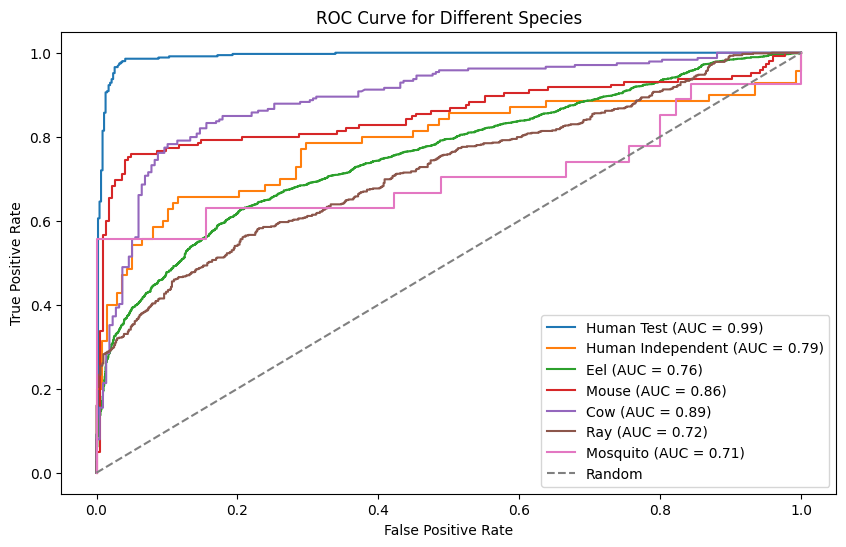

Evaluation for Human Test dataset:
Accuracy: 0.9694
Precision: 0.9603
Recall: 0.9686
F1 Score: 0.9644
MCC: 0.9376
Cohen's Kappa: 0.9375
Predicted Positives: 353.0000
Predicted Negatives: 463.0000


Evaluation for Human Independent dataset:
Accuracy: 0.7308
Precision: 0.5875
Recall: 0.6714
F1 Score: 0.6267
MCC: 0.4199
Cohen's Kappa: 0.4176
Predicted Positives: 80.0000
Predicted Negatives: 128.0000


Evaluation for Eel dataset:
Accuracy: 0.7307
Precision: 0.6571
Recall: 0.6161
F1 Score: 0.6360
MCC: 0.4232
Cohen's Kappa: 0.4226
Predicted Positives: 1954.0000
Predicted Negatives: 3505.0000


Evaluation for Mouse dataset:
Accuracy: 0.7636
Precision: 0.6667
Recall: 0.8000
F1 Score: 0.7273
MCC: 0.5284
Cohen's Kappa: 0.5217
Predicted Positives: 174.0000
Predicted Negatives: 194.0000


Evaluation for Cow dataset:
Accuracy: 0.8184
Precision: 0.8047
Recall: 0.8619
F1 Score: 0.8323
MCC: 0.6365
Cohen's Kappa: 0.6347
Predicted Positives: 256.0000
Predicted Negatives: 201.0000


Evaluation for Ray da

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, cohen_kappa_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Assuming you have a dictionary of datasets
datasets = {
    'Human Test': test_df,
    'Human Independent': df_humanIndependent_tpot_final,
    'Eel': df_eel_tpot_final,
    'Mouse': df_mouse_tpot_final,
    'Cow': df_cow_tpot_final,
    'Ray': df_ray_tpot_final,
    'Mosquito': df_mosquito_tpot_final
}

# Set up the plot
plt.figure(figsize=(10, 6))

# Initialize a dictionary to store evaluation metrics for each dataset
evaluation_metrics = {}

# Initialize a dictionary to store predictions and probabilities for each dataset
prediction_data = {}

# Evaluate and plot ROC curve for each dataset
for species, data in datasets.items():
    X = data.loc[:, 0:]
    y = data['single-class-label']
    # Get predicted probabilities for each class
    y_probs = best_pipeline.predict_proba(X)

    # Extract probabilities for each class
    y_prob_negative = y_probs[:, 0]  # Probability for the negative class
    y_prob_positive = y_probs[:, 1]  # Probability for the positive class

    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y, y_prob_positive)
    roc_auc = auc(fpr, tpr)

    # Evaluate the model
    y_pred = best_pipeline.predict(X)
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    mcc = matthews_corrcoef(y, y_pred)
    cohen_kappa = cohen_kappa_score(y, y_pred)

    # Confusion Matrix
    cm = confusion_matrix(y, y_pred)

    # Include predicted positives and negatives
    predicted_positives = sum(y_pred == 1)
    predicted_negatives = sum(y_pred == 0)

    # Store the evaluation metrics in the dictionary
    evaluation_metrics[species] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'MCC': mcc,
        "Cohen's Kappa": cohen_kappa,
        'Predicted Positives': predicted_positives,
        'Predicted Negatives': predicted_negatives
    }

    # Store the predictions, true labels, and probabilities in a DataFrame
    df_predictions_species = pd.DataFrame({
        'True_Labels': y,
        'Predictions': y_pred,
        'Probabilities_Negative': y_prob_negative,
        'Probabilities_Positive': y_prob_positive
    })

    # Reset the index to start from 0
    df_predictions_species.reset_index(drop=True, inplace=True)

    # Save the DataFrame to an Excel file
    df_predictions_species.to_excel(f'{species}_tpot_predictions_data.xlsx', index_label='Index')

    # Plot the ROC curve for each species
    plt.plot(fpr, tpr, label=f'{species} (AUC = {roc_auc:.2f})')

    # Display Confusion Matrix
    print(f"Confusion Matrix for {species} dataset:")
    print(cm)

# Plot settings
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.title('ROC Curve for Different Species')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# Display or analyze the stored evaluation metrics
for species, metrics in evaluation_metrics.items():
    print(f"Evaluation for {species} dataset:")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")
    print("\n")

# Create a DataFrame from the evaluation_metrics dictionary
df_metrics = pd.DataFrame(evaluation_metrics).transpose()

# Save the DataFrames to Excel files
df_metrics.to_excel('evaluation_metrics_tpot.xlsx', index_label='Species')


### Dataset preparation for aggregrate model evaluation

In [ ]:
df_humanIndependent_features_optimized=df_humanIndependent_features[optimized_column]
df_eel_features_optimized=df_eel_features[optimized_column]
df_mouse_features_optimized=df_mouse_features[optimized_column]
df_cow_features_optimized=df_cow_features[optimized_column]
df_ray_features_optimized=df_ray_features[optimized_column]
df_mosquito_features_optimized=df_mosquito_features[optimized_column]

In [ ]:
df_humanIndependent_optimized_final=pd.merge(df_humanIndependent[['cleanedMol', 'binary_activities']], df_humanIndependent_features_optimized, left_index=True, right_index=True)

In [ ]:
df_eel_optimized_final=pd.merge(df_eel[['cleanedMol', 'single-class-label']], df_eel_features_optimized, left_index=True, right_index=True)

In [ ]:
df_mouse_optimized_final=pd.merge(df_mouse[['cleanedMol', 'single-class-label']], df_mouse_features_optimized, left_index=True, right_index=True)
df_cow_optimized_final=pd.merge(df_cow[['cleanedMol', 'single-class-label']], df_cow_features_optimized, left_index=True, right_index=True)
df_ray_optimized_final=pd.merge(df_ray[['cleanedMol', 'single-class-label']], df_ray_features_optimized, left_index=True, right_index=True)
df_mosquito_optimized_final=pd.merge(df_mosquito[['cleanedMol', 'single-class-label']], df_mosquito_features_optimized, left_index=True, right_index=True)

In [ ]:
df_humanIndependent_optimized_final.rename(columns={'binary_activities': 'single-class-label'}, inplace=True)


In [ ]:
df_humanIndependent_optimized_final.loc[:, 2:]

,2,3,6,10,14,21,27,29,31,33,...,1572,1574,1575,1576,1579,1581,1598,1602,1607,1611
0,0,1,4.755033,4.017316,18.071927,0,2,0,1,0,...,0.016844,0.010425,0.009702,0.007108,8,0.500000,0.0,0.0,2447,9.500000
1,0,2,4.809776,3.712587,92.099007,0,2,0,0,0,...,0.013770,0.009363,0.006302,0.006909,12,0.500000,0.0,0.0,8692,14.472222
2,0,2,4.809457,3.640736,163.588722,0,2,0,0,0,...,0.014753,0.007066,0.007330,0.005056,13,0.500000,0.0,0.0,10252,14.972222
3,0,2,4.975976,3.858892,243.210138,0,2,0,0,0,...,0.013483,0.007538,0.006551,0.005979,12,0.500000,0.0,0.0,9887,14.333333
4,0,1,4.997788,3.684240,5.122509,0,0,0,0,0,...,0.013061,0.000000,0.000000,0.000000,4,0.428571,0.0,0.0,378,4.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,0,1,4.864164,4.109012,59.847438,0,3,0,0,0,...,0.020254,0.008591,0.007963,0.004982,10,0.473684,0.0,0.0,3555,9.611111
204,0,1,4.915806,4.163391,88.876337,0,4,0,0,0,...,0.020707,0.009033,0.008500,0.005653,10,0.500000,0.0,0.0,4178,10.722222
205,0,2,4.810883,3.837586,52.461806,0,2,0,0,0,...,0.014310,0.008041,0.008620,0.007938,11,0.500000,0.0,0.0,7292,13.972222
206,0,2,4.809388,3.607430,150.089915,0,2,0,0,0,...,0.013522,0.006878,0.004514,0.006249,12,0.500000,0.0,0.0,7016,12.250000


### Test dataset prepration for evaluation- best model on aggregrate modeling

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(feature_dataframe, target, test_size=0.20, random_state=42)


In [ ]:
X_test

,2,3,6,10,14,21,27,29,31,33,...,1572,1574,1575,1576,1579,1581,1598,1602,1607,1611
1749,0,1,4.703307,4.501263,10.739533,0,0,0,1,0,...,0.011034,0.006464,0.003151,0.005490,9,0.500000,0.000000,0.000000,2492,6.777778
2053,0,1,4.738906,3.624497,245.850734,0,5,0,0,0,...,0.015438,0.008894,0.006362,0.006122,11,0.476190,0.000000,0.000000,3909,9.888889
538,0,1,4.709008,3.633376,36.151294,0,1,0,0,0,...,0.015860,0.008412,0.006459,0.003734,9,0.470588,2.397895,6.823286,2536,7.388889
438,0,1,4.949217,3.787151,4352.124356,0,0,0,0,0,...,0.010014,0.005589,0.004613,0.003918,10,0.473684,0.000000,0.000000,3364,8.166667
2685,0,1,4.789013,3.882651,46.877450,0,3,0,0,0,...,0.019049,0.006633,0.006392,0.008200,9,0.470588,3.044522,7.285507,2718,8.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2765,0,1,4.572236,3.962386,49.460615,0,2,0,0,0,...,0.012063,0.006047,0.007406,0.004999,10,0.500000,0.000000,0.000000,2898,8.555556
3937,0,2,4.559271,4.518608,6.696825,0,3,0,0,0,...,0.014942,0.007970,0.009531,0.006970,8,0.500000,0.000000,0.000000,1684,8.166667
221,0,0,4.893027,4.430042,23.545140,0,5,0,0,0,...,0.012828,0.006538,0.004946,0.002816,8,0.500000,0.000000,0.000000,5501,9.500000
2031,0,1,4.559701,4.424470,7.064314,0,1,0,0,0,...,0.016475,0.004563,0.004258,0.005384,8,0.500000,0.000000,0.000000,1702,6.055556


In [ ]:
df

,Molecule ChEMBL ID,Smiles,IC50,classLabel,IsValidSMILES,Morgan_FP,Molecule,Fingerprint,PCA1,PCA2,...,1603,1604,1605,1606,1607,1608,1609,1610,1611,1612
0,CHEMBL94,CNC(=O)Oc1ccc2c(c1)[C@]1(C)CCN(C)[C@@H]1N2C,28.00,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e880b0>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-1.738898,-1.494784,...,10.241566,71.128822,275.163377,6.711302,760,36,112,139,7.590278,4.319444
1,CHEMBL207777,Cc1ccccc1NC(=O)Oc1ccc2c(c1)[C@]1(C)CO[C@@H](C1)O2,97.00,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e88190>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-1.014164,-1.325272,...,10.285513,73.449036,325.131408,7.561196,1406,39,134,160,7.090278,5.055556
2,CHEMBL205967,CCNC(=O)Oc1ccc2c(c1)[C@]1(C)CO[C@@H](C1)O2,2420.00,0,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e88270>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-1.235565,-1.559108,...,10.058909,67.227266,263.115758,7.308771,700,30,104,124,6.118056,4.111111
3,CHEMBL60119,Cc1ccc2c(N)c3c(nc2c1)CCCC3,100.00,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e88430>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,2.705664,0.148113,...,9.904837,49.157421,212.131349,6.629105,395,27,88,106,4.666667,3.444444
4,CHEMBL294525,CCCCCCCNc1c2c(nc3cc([N+](=O)[O-])ccc13)CCCC2,290.00,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfd8e884a0>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,3.600017,-0.978574,...,10.109078,59.624354,341.210327,6.561737,1596,39,126,147,7.527778,5.722222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4072,CHEMBL4077157,O=C(Nc1ccc(CN2CCOCC2)cc1C(=O)C(=O)N1C(=O)CCC1=...,229.08,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfdd327c30>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-0.478199,1.261641,...,10.351789,82.995012,449.158685,8.020691,3211,52,172,202,10.472222,7.277778
4073,CHEMBL3906317,COc1cccc2c1C=[N+](c1ccccc1C(F)(F)F)CC2.[Br-],10000.00,0,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfdd327ca0>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-0.671263,-0.016301,...,10.161573,56.557574,306.110025,8.273244,996,37,118,140,7.479167,4.777778
4074,CHEMBL4800328,COc1cccc2cc[n+](-c3ccc(C)cc3)cc12.[Br-],1080.00,0,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfdd327d10>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-0.586529,-0.433179,...,9.892578,52.541038,250.122641,7.146361,702,30,100,118,5.416667,4.250000
4075,CHEMBL4797670,COc1ccc(-[n+]2ccc3cccc(OC)c3c2)cc1.[Br-],140.00,1,True,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.Chem.rdchem.Mol object at 0x7bcfdd327d80>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,-0.677524,-0.748477,...,9.924515,53.723654,266.117555,7.392154,830,32,104,123,5.666667,4.583333


In [ ]:
test_df = pd.merge(df[['cleanedMol', 'classLabel']], X_test, left_index=True, right_index=True, how='inner')

In [ ]:
test_df.rename(columns={'classLabel': 'single-class-label'}, inplace=True)


In [ ]:
test_df

,cleanedMol,single-class-label,2,3,6,10,14,21,27,29,...,1572,1574,1575,1576,1579,1581,1598,1602,1607,1611
6,Nc1c2c(nc3ccccc13)CCCC2,1,0,0,4.919908,3.609996,4.970735,0,0,0,...,0.013061,0.000000,0.000000,0.000000,4,0.428571,0.000000,0.000000,326,3.805556
8,O=[N+]([O-])OCCCNCCCCNc1c2c(nc3ccccc13)CCCC2,1,0,1,4.949217,3.787249,638.620006,0,3,0,...,0.011126,0.006471,0.005382,0.004609,8,0.500000,0.000000,0.000000,2322,7.416667
12,COc1ccc(C(=O)c2ccc(CN(C)Cc3ccccc3)cc2)cc1,0,0,1,4.699657,4.284112,11.291753,0,2,0,...,0.020157,0.007078,0.009653,0.007225,9,0.470588,0.000000,0.000000,2022,7.777778
14,C=CC[N+](C)(C)c1ccc(OC(C)=O)cc1,0,0,1,4.704822,3.479616,5.606559,0,2,0,...,0.029206,0.006173,0.013333,0.000000,5,0.500000,0.000000,0.000000,478,7.145833
17,CN(CCCCCCCOc1ccc2c(=O)c3ccccc3oc2c1)Cc1ccccc1Cl,0,0,1,4.948098,3.831141,1729.621327,0,3,0,...,0.014931,0.007216,0.005104,0.005740,11,0.476190,0.000000,0.000000,4374,9.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4053,N#Cc1ccc(CN2CCC(Nc3nc(-c4ccc(Cl)cc4)c(-c4ccc(C...,0,0,1,4.809404,4.424723,34.335161,0,0,0,...,0.017653,0.006820,0.008134,0.007669,10,0.473684,2.397895,6.842683,4328,9.472222
4064,CNc1nc(NCCc2ccccc2)c2ccccc2n1,0,0,0,4.811456,3.671775,15.739788,0,0,0,...,0.012718,0.005935,0.003792,0.004617,6,0.454545,0.000000,0.000000,1004,5.305556
4070,CC(C)=CCC[C@]1(C)[C@@H](CC=C(C)C)C[C@@]2(CC=C(...,0,0,0,5.495373,4.721772,22.656510,2,6,0,...,0.025572,0.013244,0.009321,0.007394,6,0.500000,2.397895,7.095893,4557,19.833333
4071,O=C1C(=O)N(C(=O)c2ccccc2)c2ccc(CN3CCCCC3)cc21,1,0,1,4.900828,4.013805,15.418998,0,3,0,...,0.017320,0.012154,0.008692,0.005400,7,0.500000,2.397895,7.208600,1705,7.500000


### Evulation of species dataset on aggregrate model

Confusion Matrix for Human Test dataset:
[[426  40]
 [ 80 270]]
Confusion Matrix for Human Independent dataset:
[[128  10]
 [ 40  30]]
Confusion Matrix for Eel dataset:
[[3077  298]
 [1200  884]]
Confusion Matrix for Mouse dataset:
[[199  24]
 [ 79  66]]
Confusion Matrix for Cow dataset:
[[191  27]
 [ 88 151]]
Confusion Matrix for Ray dataset:
[[622  97]
 [376 311]]
Confusion Matrix for Mosquito dataset:
[[38  7]
 [23  4]]


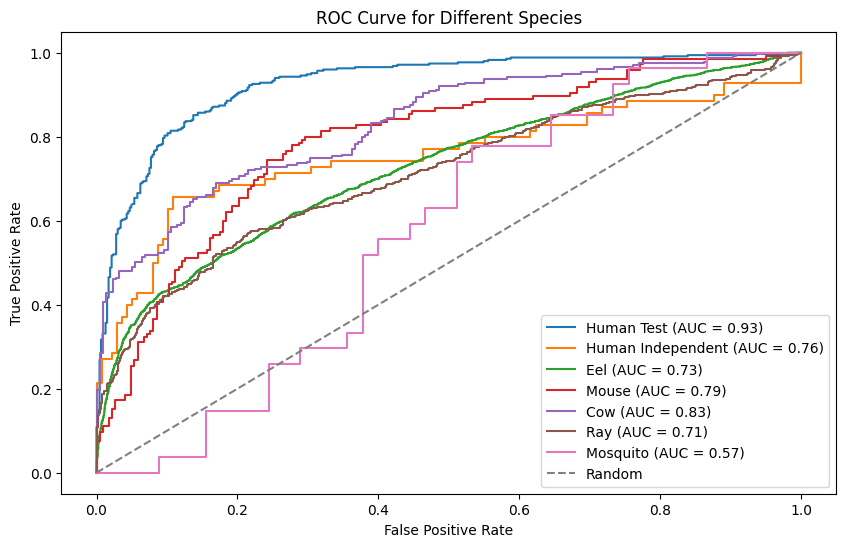

Evaluation for Human Test dataset:
Accuracy: 0.8529
Precision: 0.8710
Recall: 0.7714
F1 Score: 0.8182
MCC: 0.6991
Cohen's Kappa: 0.6955
Predicted Positives: 310.0000
Predicted Negatives: 506.0000


Evaluation for Human Independent dataset:
Accuracy: 0.7596
Precision: 0.7500
Recall: 0.4286
F1 Score: 0.5455
MCC: 0.4270
Cohen's Kappa: 0.3981
Predicted Positives: 40.0000
Predicted Negatives: 168.0000


Evaluation for Eel dataset:
Accuracy: 0.7256
Precision: 0.7479
Recall: 0.4242
F1 Score: 0.5413
MCC: 0.3962
Cohen's Kappa: 0.3662
Predicted Positives: 1182.0000
Predicted Negatives: 4277.0000


Evaluation for Mouse dataset:
Accuracy: 0.7201
Precision: 0.7333
Recall: 0.4552
F1 Score: 0.5617
MCC: 0.3951
Cohen's Kappa: 0.3722
Predicted Positives: 90.0000
Predicted Negatives: 278.0000


Evaluation for Cow dataset:
Accuracy: 0.7484
Precision: 0.8483
Recall: 0.6318
F1 Score: 0.7242
MCC: 0.5203
Cohen's Kappa: 0.5018
Predicted Positives: 178.0000
Predicted Negatives: 279.0000


Evaluation for Ray dat

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, cohen_kappa_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Assuming you have a dictionary of datasets
datasets = {
    'Human Test': test_df,
    'Human Independent': df_humanIndependent_optimized_final,
    'Eel': df_eel_optimized_final,
    'Mouse': df_mouse_optimized_final,
    'Cow': df_cow_optimized_final,
    'Ray': df_ray_optimized_final,
    'Mosquito': df_mosquito_optimized_final
}

# Set up the plot
plt.figure(figsize=(10, 6))

# Initialize a dictionary to store evaluation metrics for each dataset
evaluation_metrics = {}

# Initialize a dictionary to store predictions and probabilities for each dataset
prediction_data = {}

# Evaluate and plot ROC curve for each dataset
for species, data in datasets.items():
    # Assuming your target variable is named 'single-class-label'
    scaler = StandardScaler()
    X = scaler.fit_transform(data.loc[:, 2:])
    y = data['single-class-label']

    # Get predicted probabilities for each class
    y_probs = best_single_model.predict_proba(X)

    # Extract probabilities for each class
    y_prob_negative = y_probs[:, 0]  # Probability for the negative class
    y_prob_positive = y_probs[:, 1]  # Probability for the positive class

    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y, y_prob_positive)
    roc_auc = auc(fpr, tpr)

    # Evaluate the model
    y_pred = best_single_model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    mcc = matthews_corrcoef(y, y_pred)
    cohen_kappa = cohen_kappa_score(y, y_pred)

    # Confusion Matrix
    cm = confusion_matrix(y, y_pred)

    # Include predicted positives and negatives
    predicted_positives = sum(y_pred == 1)
    predicted_negatives = sum(y_pred == 0)

    # Store the evaluation metrics in the dictionary
    evaluation_metrics[species] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'MCC': mcc,
        "Cohen's Kappa": cohen_kappa,
        'Predicted Positives': predicted_positives,
        'Predicted Negatives': predicted_negatives
    }

    # Store the predictions, true labels, and probabilities in a DataFrame
    df_predictions_species = pd.DataFrame({
        'True_Labels': y,
        'Predictions': y_pred,
        'Probabilities_Negative': y_prob_negative,
        'Probabilities_Positive': y_prob_positive
    })

    # Reset the index to start from 0
    df_predictions_species.reset_index(drop=True, inplace=True)

    # Save the DataFrame to an Excel file
    df_predictions_species.to_excel(f'{species}_optimized_predictions_data.xlsx', index_label='Index')

    # Plot the ROC curve for each species
    plt.plot(fpr, tpr, label=f'{species} (AUC = {roc_auc:.2f})')

    # Display Confusion Matrix
    print(f"Confusion Matrix for {species} dataset:")
    print(cm)

# Plot settings
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.title('ROC Curve for Different Species')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# Display or analyze the stored evaluation metrics
for species, metrics in evaluation_metrics.items():
    print(f"Evaluation for {species} dataset:")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")
    print("\n")

# Create a DataFrame from the evaluation_metrics dictionary
df_metrics = pd.DataFrame(evaluation_metrics).transpose()

# Save the DataFrames to Excel files
df_metrics.to_excel('evaluation_metrics_optimized_specieswide.xlsx', index_label='Species')


## Conclusion

The aggregate modeling produced HistGradientBoosting with 'max_iter': 200, while TPOT identified ExtraTreesClassifier(input_matrix, bootstrap=False, criterion=entropy, max_features=0.5, min_samples_leaf=4, min_samples_split=2, n_estimators=100) as the best models. Cross-species evaluation demonstrated strong performance for both best models across all datasets, with the TPOT pipeline's superior performance noted above

## Referenes
*  Muthukrishnan, R., & Rohini, R. (2016). LASSO: A feature selection technique in predictive modeling for machine learning. 2016 IEEE International Conference on Advances in Computer Applications (ICACA), 18–20. https://doi.org/10.1109/ICACA.2016.7887916
*  Moriwaki, H., Tian, Y.-S., Kawashita, N., & Takagi, T. (2018). Mordred: A molecular descriptor calculator. Journal of Cheminformatics, 10(1), 4.
*   Vignaux, P. A., Lane, T. R., Urbina, F., Gerlach, J., Puhl, A. C., Snyder, S. H., & Ekins, S. (2023). Validation of Acetylcholinesterase Inhibition Machine Learning Models for Multiple Species. Chemical Research in Toxicology, 36(2), 188–201. https://doi.org/10.1021/acs.chemrestox.2c00283